In [2]:
using Pkg
Pkg.activate("../../")

  Activating project at `d:\Projects\Dr. Heyl Group\ising-xy-distances-study`

In [29]:
using CairoMakie
include("../../src/spinmc.jl");

In [17]:
datapath = joinpath("d:\\", "Projects", "Dr. Heyl Group", "cluster_data")
println("datapath: "* datapath)
@assert ispath(datapath)

datapath: d:\Projects\Dr. Heyl Group\cluster_data


In [21]:
lattice_sizes = [16, 32, 48, 64];
temps = [1.80, 1.90, 2.00, 2.10, 2.20, 2.21, 2.22, 2.23, 2.24, 2.25, 2.26, 2.27, 2.28, 2.29, 2.30, 2.31, 2.32, 2.33, 2.34, 2.35, 2.36, 2.37, 2.38, 2.39, 2.40, 2.50, 2.60, 2.70];

# Check magnetization of the system

In [40]:
mags, error_mags = let
    mags = zeros(Float64, (length(temps), length(lattice_sizes)))
    error_mags = zeros(Float64, (length(temps), length(lattice_sizes)))
    for stepL in eachindex(lattice_sizes)
        for stepT in eachindex(temps)
            T, L = temps[stepT], lattice_sizes[stepL]
            m_arr = readdlm(joinpath(datapath, "Ising", "Size$L", "mags", "ising_mags_temp$(T)_L$(L).txt"), ',')[:, 1]
            mags[stepT, stepL] = mean(m_arr) / L^2
            error_mags[stepT, stepL] = bootstrap_err(m_arr, mean) / L^2
        end
    end
    mags, error_mags
end;

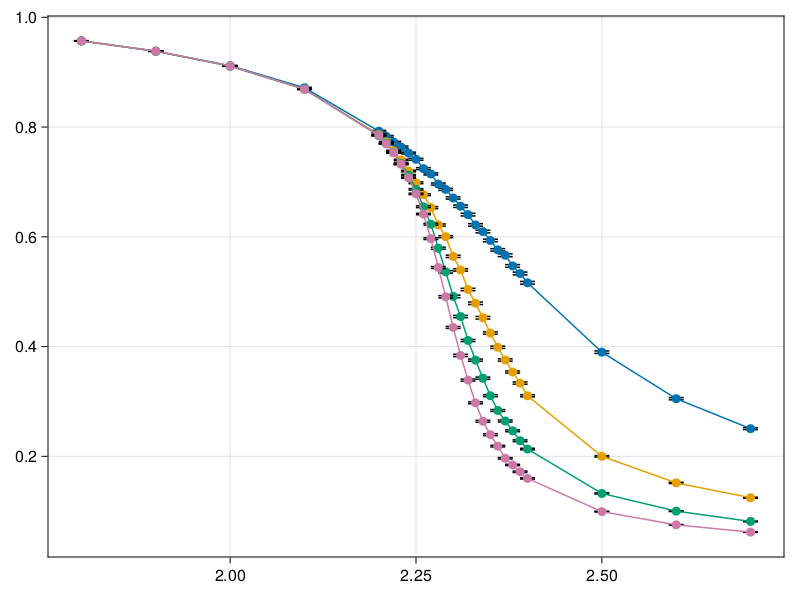

In [44]:
f1 = Figure()
ax1 = Axis(f1[1,1])

for idx=1:size(mags, 2)
    col = @view mags[:, idx]
    err = @view error_mags[:, idx]
    errorbars!(ax1, temps, col, err, whiskerwidth=15)
    scatterlines!(ax1, temps, col)
end
f1

# Structure factors

In [46]:
struc_facs, error_struc_facs = let
    struc_facs = zeros(Float64, (length(temps), length(lattice_sizes)))
    error_struc_facs = zeros(Float64, (length(temps), length(lattice_sizes)))
    for stepL in eachindex(lattice_sizes)
        for stepT in eachindex(temps)
            T, L = temps[stepT], lattice_sizes[stepL]
            s_arr = readdlm(joinpath(datapath, "Ising", "Size$L", "struc_facs", "ising_struc_facs_temp$(T)_L$(L).txt"), ',')[:, 1]
            struc_facs[stepT, stepL] = mean(s_arr)
            error_struc_facs[stepT, stepL] = bootstrap_err(s_arr, mean)
        end
    end
    struc_facs, error_struc_facs
end;

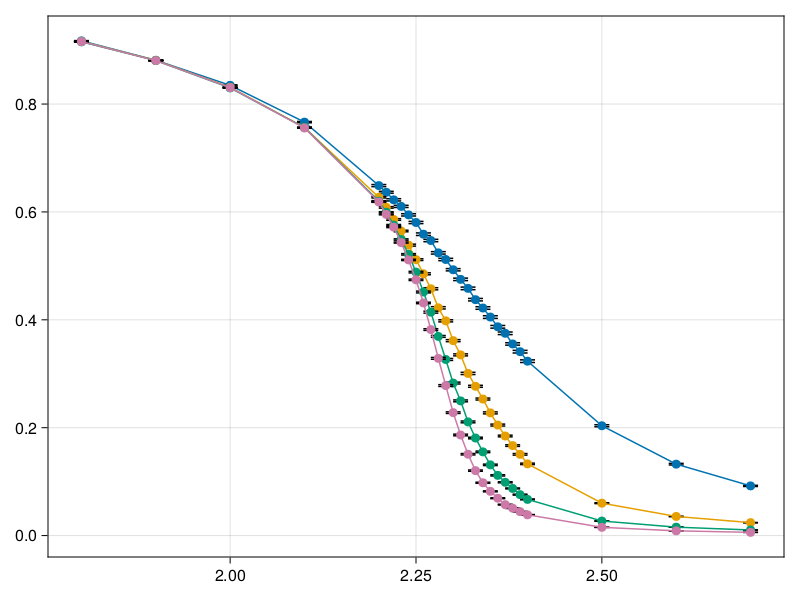

In [48]:
f2 = Figure()
ax2 = Axis(f2[1,1])

for idx=1:size(struc_facs, 2)
    col = @view struc_facs[:, idx]
    err = @view error_struc_facs[:, idx]
    errorbars!(ax2, temps, col, err, whiskerwidth=15)
    scatterlines!(ax2, temps, col)
end
f2